# Discussion of the GP marginal likelihood upper bound

See the [`gp_upper` repository](https://github.com/markvdw/gp_upper) by Mark van der Wilk for code to tighten the upper bound through optimization, and a more comprehensive discussion.

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

import numpy as np
import tensorflow as tf

import gpflow
from gpflow import set_trainable
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

import logging

logging.disable(logging.WARNING)

np.random.seed(1)

from FITCvsVFE import getTrainingTestData

2022-03-08 12:17:03.371870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 12:17:03.371902: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
X, Y, Xt, Yt = getTrainingTestData()

In [3]:
def plot_model(m, name=""):
    pX = np.linspace(-3, 9, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, "x")
    plt.plot(pX, pY)
    if not isinstance(m, gpflow.models.GPR):
        Z = m.inducing_variable.Z.numpy()
        plt.plot(Z, np.zeros_like(Z), "o")
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = m.maximum_log_likelihood_objective().numpy()
    plt.title("%s (lml = %f)" % (name, lml))
    return lml

## Full model

2022-03-08 12:17:05.323809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 12:17:05.323836: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 12:17:05.323856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (48ab5453dcce): /proc/driver/nvidia/version does not exist
2022-03-08 12:17:05.324114: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 12:17:05.351979: W tensorflow/python/util/util.cc:348] Sets are not currently considered se

2022-03-08 12:17:06.852870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


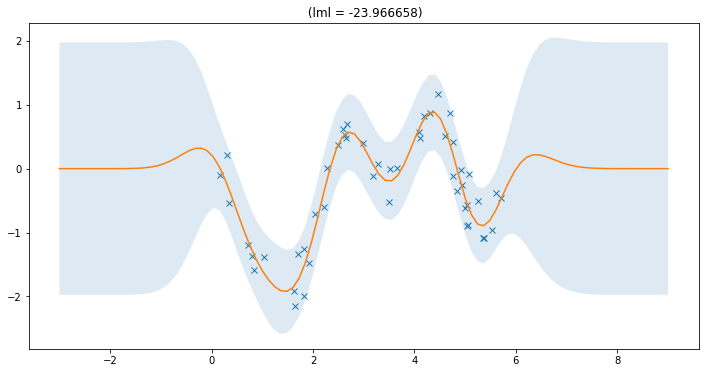

In [4]:
gpr = gpflow.models.GPR((X, Y), gpflow.kernels.SquaredExponential())
gpflow.optimizers.Scipy().minimize(
    gpr.training_loss, gpr.trainable_variables, options=dict(maxiter=ci_niter(1000))
)
full_lml = plot_model(gpr)

## Upper bounds for sparse variational models
As a first investigation, we compute the upper bound for models trained using the sparse variational GP approximation.

In [5]:
Ms = np.arange(4, ci_niter(20, test_n=6), 1)
vfe_lml = []
vupper_lml = []
vfe_hyps = []
for M in Ms:
    Zinit = X[:M, :].copy()
    vfe = gpflow.models.SGPR((X, Y), gpflow.kernels.SquaredExponential(), inducing_variable=Zinit)
    gpflow.optimizers.Scipy().minimize(
        vfe.training_loss,
        vfe.trainable_variables,
        options=dict(disp=False, maxiter=ci_niter(1000), compile=True),
    )

    vfe_lml.append(vfe.elbo().numpy())
    vupper_lml.append(vfe.upper_bound().numpy())
    vfe_hyps.append([(p.name, p.numpy()) for p in vfe.trainable_parameters])
    print("%i" % M, end=" ")

/home/circleci/project/GPflow/gpflow/optimizers/scipy.py:97: OptimizeWarning: Unknown solver options: compile
  func, initial_params, jac=True, method=method, **scipy_kwargs


4 

5 

6 

7 

8 

9 

10 

11 

12 

13 

14 

15 

16 

17 

18 

19 

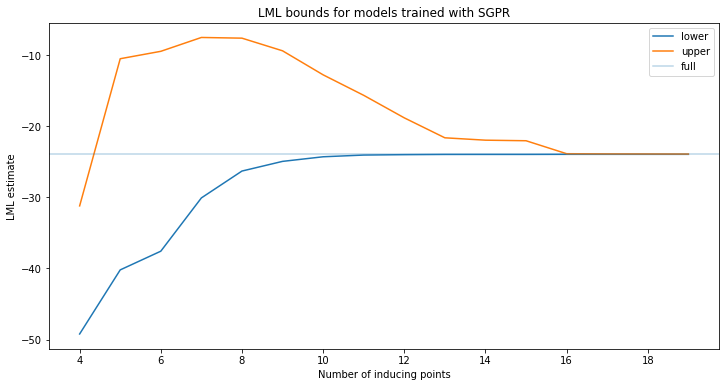

In [6]:
plt.title("LML bounds for models trained with SGPR")
plt.plot(Ms, vfe_lml, label="lower")
plt.plot(Ms, vupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
_ = plt.legend()

We see that the lower bound increases as more inducing points are added. Note that the upper bound does _not_ monotonically decrease! This is because as we train the sparse model, we also get better estimates of the hyperparameters. The upper bound will be different for this different setting of the hyperparameters, and is sometimes looser. The upper bound also converges to the true lml slower than the lower bound.

### Upper bounds for fixed hyperparameters
Here, we train sparse models with the hyperparameters fixed to the optimal value found previously.

In [7]:
fMs = np.arange(3, ci_niter(20, test_n=5), 1)
fvfe_lml = []  # Fixed vfe lml
fvupper_lml = []  # Fixed upper lml

init_params = gpflow.utilities.parameter_dict(vfe)

# cannot copy this due to shape mismatch with different numbers of inducing points between models:
del init_params[".inducing_variable.Z"]

for M in fMs:
    Zinit = vfe.inducing_variable.Z.numpy()[:M, :]
    Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[: (M - len(Zinit))], :].copy()))

    vfe = gpflow.models.SGPR((X, Y), gpflow.kernels.SquaredExponential(), inducing_variable=Zinit)

    # copy hyperparameters (omitting inducing_variable.Z) from optimized model:
    gpflow.utilities.multiple_assign(vfe, init_params)

    set_trainable(vfe.kernel, False)
    set_trainable(vfe.likelihood, False)

    gpflow.optimizers.Scipy().minimize(
        vfe.training_loss,
        vfe.trainable_variables,
        options=dict(disp=False, maxiter=ci_niter(1000)),
        compile=True,
    )

    fvfe_lml.append(vfe.elbo().numpy())
    fvupper_lml.append(vfe.upper_bound().numpy())
    print("%i" % M, end=" ")

3 

4 

5 

6 

7 

8 

9 

10 

11 

12 

13 

14 

15 

16 

17 

18 

19 

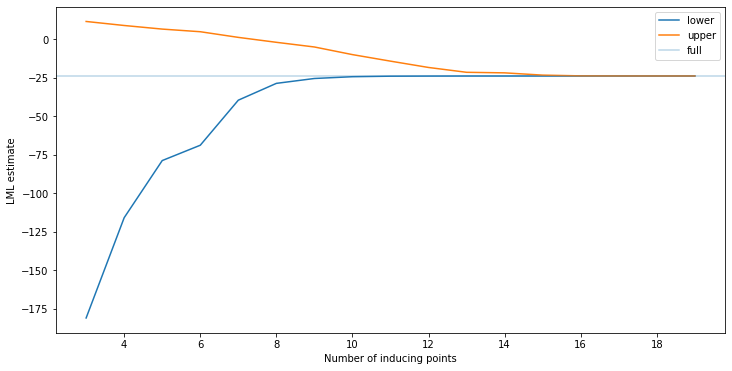

In [8]:
plt.plot(fMs, fvfe_lml, label="lower")
plt.plot(fMs, fvupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
_ = plt.legend()

In [9]:
assert np.all(np.array(fvupper_lml) - np.array(fvfe_lml) > 0.0)

Now, as the hyperparameters are fixed, the bound _does_ monotonically decrease. We chose the optimal hyperparameters here, but the picture should be the same for any hyperparameter setting. This shows that we increasingly get a better estimate of the marginal likelihood as we add more inducing points.

### A tight estimate bound does not imply a converged model

In [10]:
single_inducing_point = X[:1, :].copy()
vfe = gpflow.models.SGPR(
    (X, Y), gpflow.kernels.SquaredExponential(), inducing_variable=single_inducing_point
)
objective = tf.function(vfe.training_loss)
gpflow.optimizers.Scipy().minimize(
    objective, vfe.trainable_variables, options=dict(maxiter=ci_niter(1000)), compile=False
)
# Note that we need to set compile=False here due to a discrepancy in compiling with tf.function
# see https://github.com/GPflow/GPflow/issues/1260

print("Lower bound: %f" % vfe.elbo().numpy())
print("Upper bound: %f" % vfe.upper_bound().numpy())

Lower bound: -62.487136
Upper bound: -62.482200


In this case we show that for the hyperparameter setting, the bound is very tight. However, this does _not_ imply that we have enough inducing points, but simply that we have correctly identified the marginal likelihood for this particular hyperparameter setting. In this specific case, where we used a single inducing point, the model collapses to not using the GP at all (lengthscale is really long to model only the mean). The rest of the variance is explained by noise. This GP can be perfectly approximated with a single inducing point.

-62.48713638430225

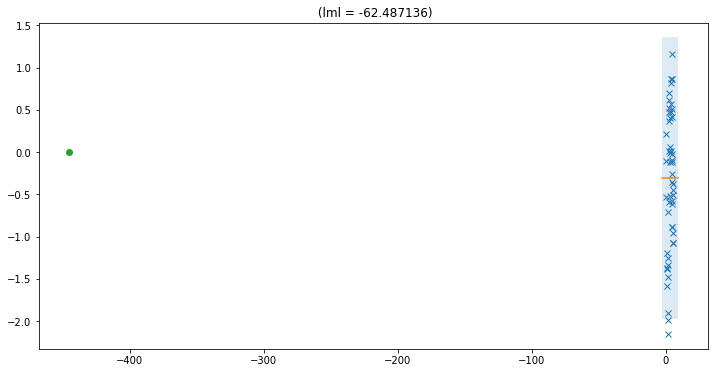

In [11]:
plot_model(vfe)

In [12]:
print_summary(vfe, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.10775391372396452
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,113261.03818130556
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.6824247532854097
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(1, 1)",float64,[[-445.15113131]]


This can be diagnosed by showing that there are other hyperparameter settings with higher upper bounds. This indicates that there might be better hyperparameter settings, but we cannot identify them due to the lack of inducing points. An example of this can be seen in the previous section.